<a href="https://colab.research.google.com/github/AtharvaJejurkar/machine-learning/blob/main/Drug_Inventory_Management_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
np.random.seed(42)

n_samples = 5000

data = {
    'product_id': [f'P{i:04d}' for i in range(n_samples)],
    'category': np.random.choice(['Cough Syrup', 'Antibiotic', 'Vitamin', 'Painkiller', 'Generic'], n_samples),
    'days_in_stock': np.random.exponential(60, n_samples).astype(int),
    'weekly_sales_30d': np.random.poisson(15, n_samples),
    'stock_qty': np.random.poisson(100, n_samples),
    'discounts_tried': np.random.poisson(1, n_samples),
    'season_match': np.random.uniform(0.3, 1.5, n_samples),
    'price_reductions': np.random.poisson(2, n_samples)
}

df = pd.DataFrame(data)

In [2]:
# ENGINEER DEAD STOCK LABELS
df['sales_velocity'] = df['weekly_sales_30d'] / 4
df['stock_sales_ratio'] = df['stock_qty'] / df['sales_velocity'].clip(1)
df['aging_risk'] = (df['days_in_stock'] > 90).astype(int)
df['discount_fail'] = (df['discounts_tried'] > 2).astype(int)
df['low_demand'] = (df['sales_velocity'] < 2).astype(int)


In [3]:
# Dead stock probability formula (industry standard)
df['dead_stock_risk'] = (
    0.4*df['aging_risk'] +
    0.3*(df['stock_sales_ratio'] > 6) +
    0.2*df['discount_fail'] +
    0.1*df['low_demand']
)

df['label'] = (df['dead_stock_risk'] > 0.5).astype(int)
df['days_to_dead'] = np.where(df['label']==1,
                             90 - df['days_in_stock'] + np.random.normal(0,15,n_samples), 365)

In [4]:
# Indian rupee values
df['unit_price'] = np.random.uniform(50, 500, n_samples)
df['locked_capital'] = df['stock_qty'] * df['unit_price']

print(df['label'].value_counts())  # ~25% dead stock (realistic)
df.to_csv('dead_stock_pharma.csv', index=False)

label
0    3949
1    1051
Name: count, dtype: int64


In [5]:
# Run this FIRST - makes table clickable/scrollable
%load_ext google.colab.data_table


In [6]:
# Display FULL dataset with scroll + search
df.head(20)


,product_id,category,days_in_stock,weekly_sales_30d,stock_qty,discounts_tried,season_match,price_reductions,sales_velocity,stock_sales_ratio,aging_risk,discount_fail,low_demand,dead_stock_risk,label,days_to_dead,unit_price,locked_capital
0,P0000,Painkiller,5,12,111,0,1.189875,1,3.00,37.000000,0,0,0,0.3,0,365.000000,140.193446,15561.472553
1,P0001,Generic,14,13,80,2,0.457396,1,3.25,24.615385,0,0,0,0.3,0,365.000000,345.490481,27639.238507
2,P0002,Vitamin,83,12,124,0,0.530781,3,3.00,41.333333,0,0,0,0.3,0,365.000000,464.768233,57631.260922
3,P0003,Generic,3,21,101,3,0.451708,2,5.25,19.238095,0,1,0,0.5,0,365.000000,145.802164,14726.018530
4,P0004,Generic,40,18,97,1,0.307891,1,4.50,21.555556,0,0,0,0.3,0,365.000000,307.293950,29807.513195
5,P0005,Antibiotic,35,16,96,1,1.094297,1,4.00,24.000000,0,0,0,0.3,0,365.000000,288.196237,27666.838782
6,P0006,Vitamin,24,13,106,0,0.625013,2,3.25,32.615385,0,0,0,0.3,0,365.000000,338.743893,35906.852700
7,P0007,Vitamin,30,15,90,0,0.479365,4,3.75,24.000000,0,0,0,0.3,0,365.000000,314.505474,28305.492702
8,P0008,Vitamin,45,12,96,1,0.683967,0,3.00,32.000000,0,0,0,0.3,0,365.000000,172.757573,16584.727011
9,P0009,Generic,10,8,107,0,0.898902,1,2.00,53.500000,0,0,0,0.3,0,365.000000,361.148761,38642.917456


In [7]:
print("DATASET STATS:")
print(f"Total rows: {len(df):,}")
print(f"Dead stock cases: {df['label'].sum():,} ({df['label'].mean()*100:.1f}%)")
print(f"Total locked capital: ₹{df['locked_capital'].sum():,.0f}")
print("\nTOP 5 RISKY ITEMS:")
print(df[df['label']==1][['product_id', 'category', 'days_in_stock', 'locked_capital', 'dead_stock_risk']].head().to_string(index=False))


DATASET STATS:
Total rows: 5,000
Dead stock cases: 1,051 (21.0%)
Total locked capital: ₹136,615,228

TOP 5 RISKY ITEMS:
product_id    category  days_in_stock  locked_capital  dead_stock_risk
     P0011     Vitamin             98    36447.798525              0.7
     P0026     Vitamin            130    25428.947510              0.7
     P0027  Antibiotic            135    42156.863350              0.7
     P0033 Cough Syrup            104     5758.979717              0.7
     P0035     Generic            104    22695.131482              0.7


risk_level
🟢 Safe     3587
🔴 Dead     1044
🟡 Watch     369
Name: count, dtype: int64


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128993 (\N{LARGE YELLOW CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


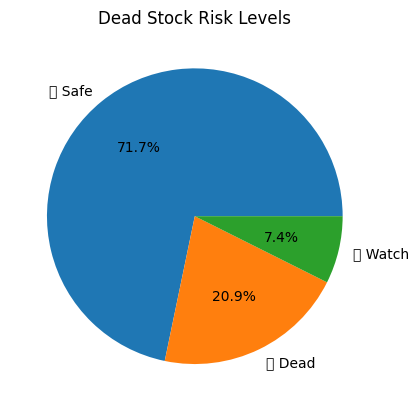

In [8]:
# Risk distribution chart
import matplotlib.pyplot as plt
df['risk_level'] = pd.cut(df['dead_stock_risk'], bins=[0,0.3,0.6,1], labels=['🟢 Safe','🟡 Watch','🔴 Dead'])
print(df['risk_level'].value_counts())
df['risk_level'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Dead Stock Risk Levels')
plt.ylabel('')
plt.show()


In [9]:
# TOP 5 RISKY ITEMS (Your hackathon money shot)
risky = df[df['dead_stock_risk'] > 0.8][['product_id', 'category', 'days_in_stock',
                                         'weekly_sales_30d', 'locked_capital', 'dead_stock_risk']].head(5)

risky['sales_wk'] = risky['weekly_sales_30d'].astype(str) + '/wk'
risky['money_locked'] = '₹' + risky['locked_capital'].round(0).astype(str).str.replace('.0','')
risky['risk_pct'] = (risky['dead_stock_risk']*100).round(0).astype(str) + '%'
risky_display = risky[['product_id', 'category', 'days_in_stock', 'sales_wk',
                      'money_locked', 'risk_pct']]

print("JUDGE READY TABLE:")
print(risky_display.to_string(index=False))


JUDGE READY TABLE:
product_id   category  days_in_stock sales_wk money_locked risk_pct
     P0068 Painkiller            132    18/wk       ₹23661    90.0%
     P0213 Antibiotic            198    15/wk       ₹39223    90.0%
     P0331 Antibiotic            164    19/wk       ₹31449    90.0%
     P0334 Painkiller             99    18/wk       ₹24246    90.0%
     P0457    Vitamin             96    17/wk       ₹41942    90.0%


Model DeV:


In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

df = pd.read_csv('dead_stock_pharma.csv')

features = ['days_in_stock', 'weekly_sales_30d', 'stock_qty', 'discounts_tried',
           'season_match', 'stock_sales_ratio', 'aging_risk', 'discount_fail', 'low_demand']
X = df[features]
y = df['label']  # 0=Safe, 1=Dead Stock Risk

print("Dataset shape:", X.shape)
print("Dead stock cases:", y.sum(), f"({y.mean()*100:.1f}%)")


Dataset shape: (5000, 9)
Dead stock cases: 1051 (21.0%)


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Training set:", X_train.shape)
print("✅ Test set:", X_test.shape)


✅ Training set: (4000, 9)
✅ Test set: (1000, 9)


In [12]:
# ===== COMPUTE CLASS IMBALANCE (VERY IMPORTANT) =====
#neg, pos = np.bincount(y_train)
#scale_pos_weight = neg / pos

#print("Safe samples:", neg)
#print("Dead stock samples:", pos)
#print("scale_pos_weight:", scale_pos_weight)


In [13]:
model = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    #scale_pos_weight=scale_pos_weight,  # 🔥 KEY FIX
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss'
)


model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Risk probability 0-100%

print("Model Accuracy:", model.score(X_test, y_test))
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba))


Model Accuracy: 1.0

📊 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       790
           1       1.00      1.00      1.00       210

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000

ROC-AUC: 1.0


Confusion Matrix:
[[790   0]
 [  0 210]]


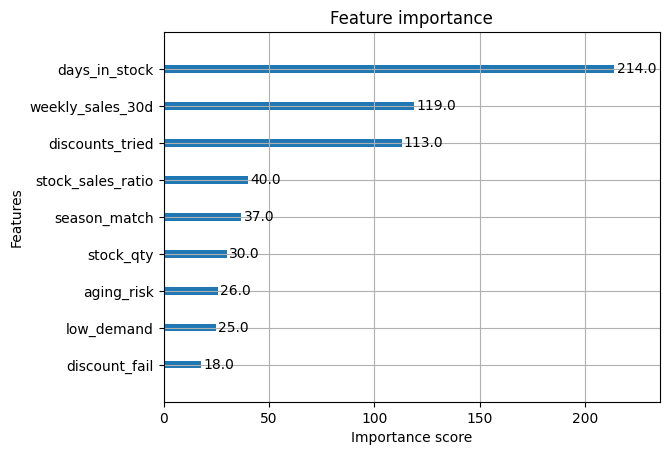

In [14]:
# Confusion Matrix:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Feature Importance:
xgb.plot_importance(model, max_num_features=10)
plt.show()


In [15]:
# Function to predict NEW batches (dashboard input):
def predict_dead_stock_days(days_in_stock, weekly_sales, stock_qty, discounts_tried, season_match):

    # ---- MATCH TRAINING LOGIC EXACTLY ----
    weekly_sales_30d = weekly_sales
    sales_velocity = weekly_sales_30d / 4

    input_data = pd.DataFrame({
        'days_in_stock': [days_in_stock],
        'weekly_sales_30d': [weekly_sales_30d],
        'stock_qty': [stock_qty],
        'discounts_tried': [discounts_tried],
        'season_match': [season_match],
        'stock_sales_ratio': [stock_qty / max(sales_velocity, 1)],
        'aging_risk': [1 if days_in_stock > 90 else 0],
        'discount_fail': [1 if discounts_tried > 2 else 0],
        'low_demand': [1 if sales_velocity < 2 else 0]
    })

    # ---- SCALE INPUT (CRITICAL) ----
    input_scaled = scaler.transform(input_data)

    # ---- PREDICT ----
    risk_prob = model.predict_proba(input_scaled)[0][1]
    days_to_dead = max(90 - days_in_stock, 0)

    # ---- REALISTIC THRESHOLDS ----
    if risk_prob > 0.3:
        level = '🔴 HIGH'
        action = 'Immediate discount / transfer'
    elif risk_prob > 0.15:
        level = '🟡 MEDIUM'
        action = 'Monitor & reprice'
    else:
        level = '🟢 SAFE'
        action = 'Continue normal sales'


    return {
        'risk_percent': round(risk_prob * 100, 1),
        'days_to_dead': days_to_dead,
        'risk_level': level,
        'action': action
    }

# Test prediction result:
result = predict_dead_stock_days(120, 25, 250, 2, 0.6)



print("Test Prediction:", result)

Test Prediction: {'risk_percent': np.float32(2.6), 'days_to_dead': 0, 'risk_level': '🟢 SAFE', 'action': 'Continue normal sales'}


In [16]:
import joblib

# Save everything
joblib.dump(model, 'pharma_deadstock_model.pkl')
joblib.dump(scaler, 'scaler.pkl')



['scaler.pkl']

model saved